In [389]:
# Installing requirements
# %pip install -r requirements.txt

In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

In [391]:
df = pd.read_csv('recipe_site_traffic_2212.csv')

In [392]:
# Size of dataset
df.shape

(947, 8)

In [393]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [394]:
df.drop(columns=["recipe"], inplace=True)

In [395]:
# Checking data types

df.dtypes

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

In [396]:
# Replace null with "0"
df["high_traffic"] = df["high_traffic"].fillna("0")
# Replace "High" with "1"
df["high_traffic"] = df["high_traffic"].replace("High", "1")
# COnvert to int
df["high_traffic"] = pd.to_numeric(df["high_traffic"]).astype(int)


In [397]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,NaN,NaN,NaN,NaN,Pork,6,1
1,35.48,38.56,0.66,0.92,Potato,4,1
2,914.28,42.68,3.09,2.88,Breakfast,1,0
3,97.03,30.56,38.63,0.02,Beverages,4,1
4,27.05,1.85,0.80,0.53,Beverages,4,0


In [398]:
# Percentage of missing values
df.isna().sum() / len(df) * 100

calories        5.491024
carbohydrate    5.491024
sugar           5.491024
protein         5.491024
category        0.000000
servings        0.000000
high_traffic    0.000000
dtype: float64

In [399]:
df[df["calories"].isna()].head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,NaN,NaN,NaN,NaN,Pork,6,1
23,NaN,NaN,NaN,NaN,Meat,2,0
48,NaN,NaN,NaN,NaN,Chicken Breast,4,0
82,NaN,NaN,NaN,NaN,Meat,4,1
89,NaN,NaN,NaN,NaN,Pork,6,1


It appears that `calories`, `carbohydrate`, `sugar`, `protein` always miss together

My strategy to fill in null values
1. Split rows based on `category`
2. Plot distributions of columns above to determine what measure of central tendency will be used to impute i.e mean, mode, median.
- Plotting is to check for _skew_ and _modality_
3. Impute accordingly

# Handling missing values

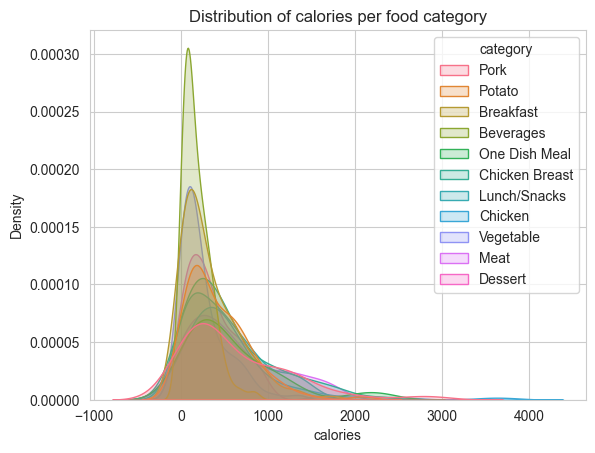

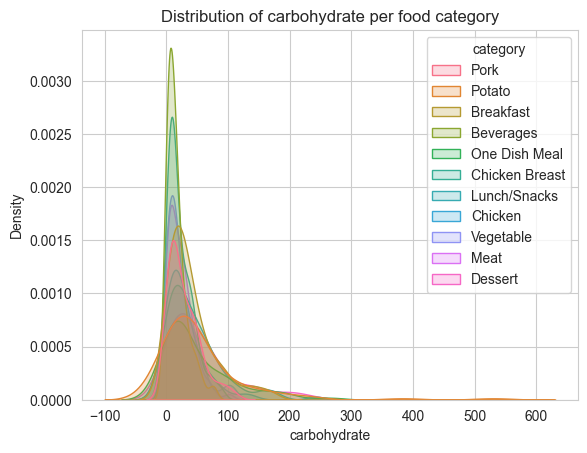

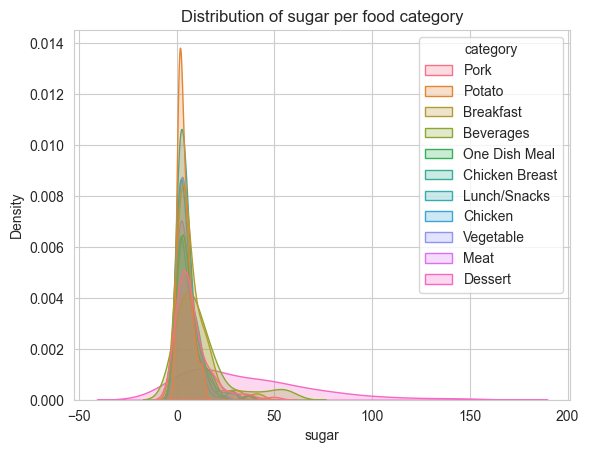

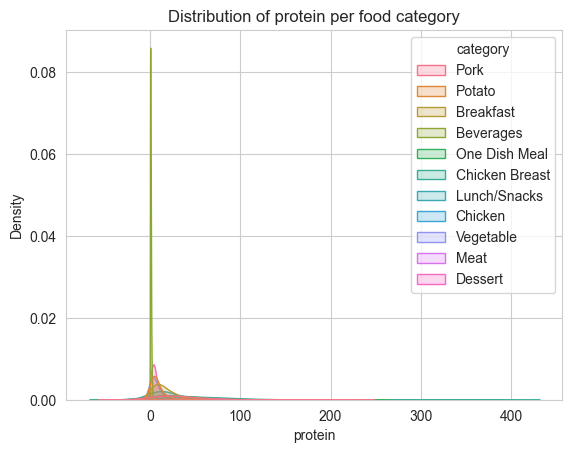

In [400]:
columns_with_missing_values = ["calories", "carbohydrate", "sugar", "protein"]

for column in columns_with_missing_values:
    sns.kdeplot(x=df[column], hue=df["category"], fill=True)
    plt.title(f"Distribution of {column} per food category")
    plt.show()


Data is left skewed for all food categories, the median shall be used for imputation

In [401]:
for column in columns_with_missing_values:
    df[column] = df[column].fillna(df[column].median())   

# Handling duplicate values

In [402]:
df.duplicated().sum()

np.int64(23)

There are no duplicate values

# Checking class imbalance

In [403]:
df["high_traffic"].value_counts(normalize=True)

high_traffic
1    0.606125
0    0.393875
Name: proportion, dtype: float64

# Check distributions of categorical columns

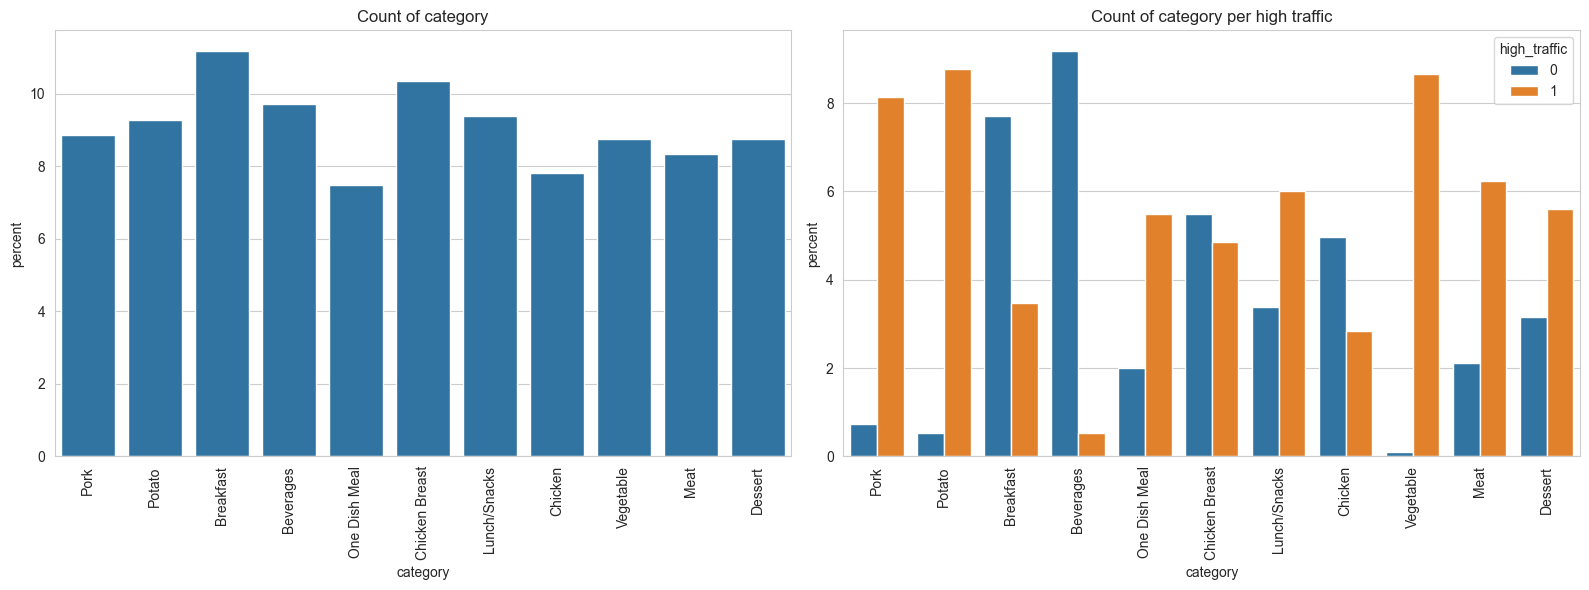

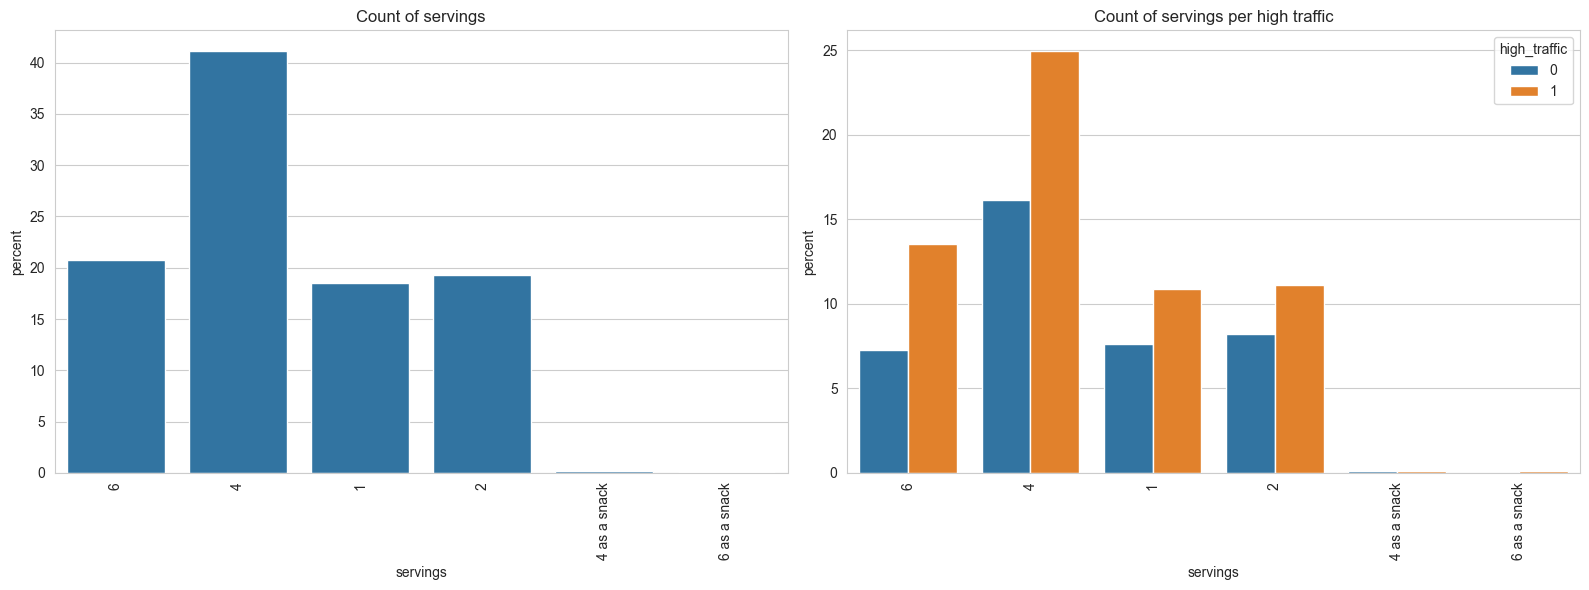

In [404]:
categorical_columns = df.select_dtypes(include=["object"]).columns

categorical_columns_df = df.loc[:, categorical_columns]

categorical_columns_df.loc[:, "high_traffic"] = df.loc[:, "high_traffic"]

for column in categorical_columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.countplot(ax=axes[0], x=categorical_columns_df[column], stat="percent")
    axes[0].set_title(f"Count of {column}")
    axes[0].tick_params(axis="x", labelrotation=90)

    sns.countplot(
        ax=axes[1],
        x=categorical_columns_df[column],
        hue=df["high_traffic"],
        stat="percent",
    )
    
    axes[1].set_title(f"Count of {column} per high traffic")
    axes[1].tick_params(axis="x", labelrotation=90)

    plt.tight_layout()
    plt.show()

# Checking distributions of numerical columns

Index(['calories', 'carbohydrate', 'sugar', 'protein'], dtype='object')


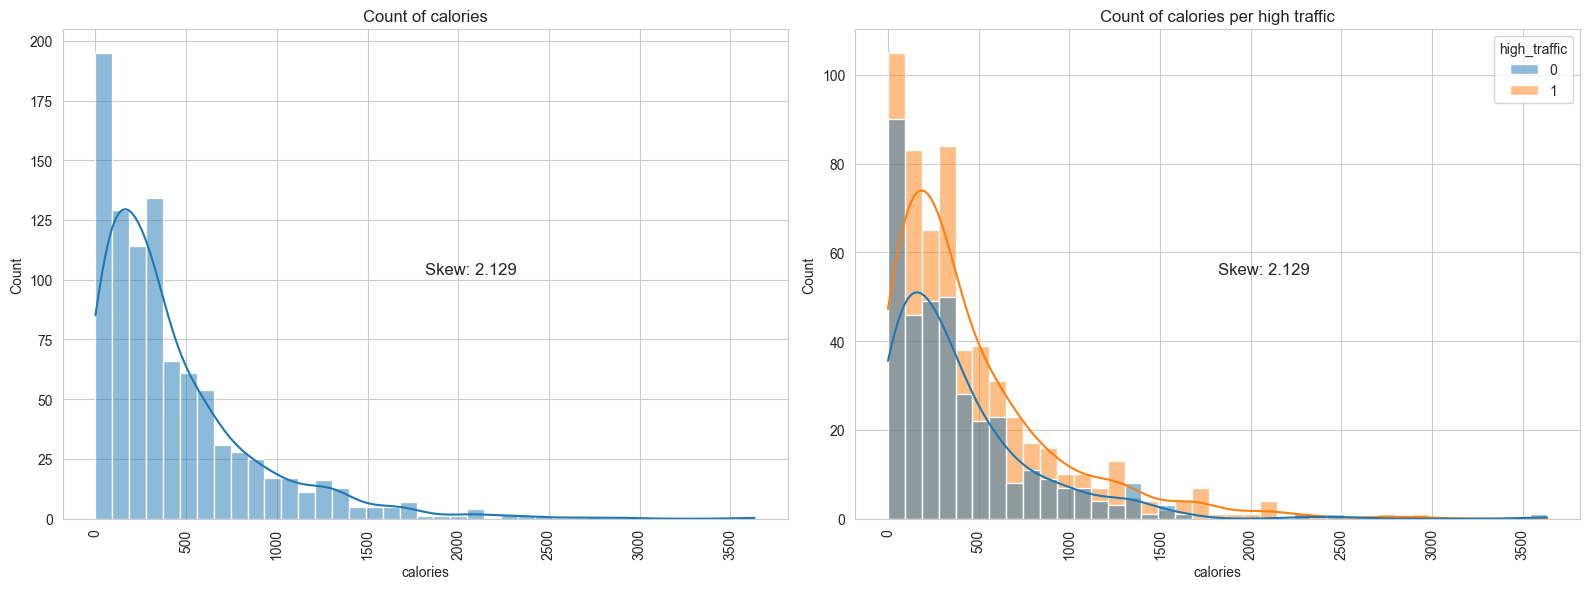

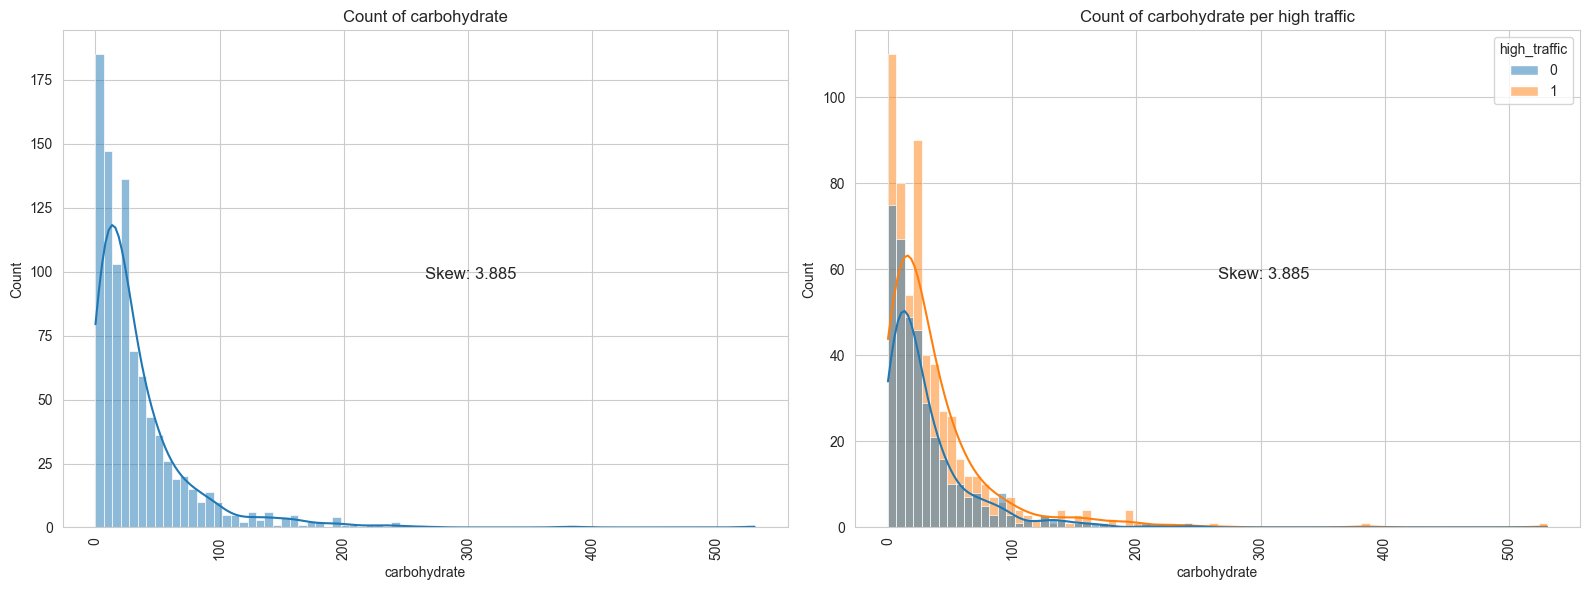

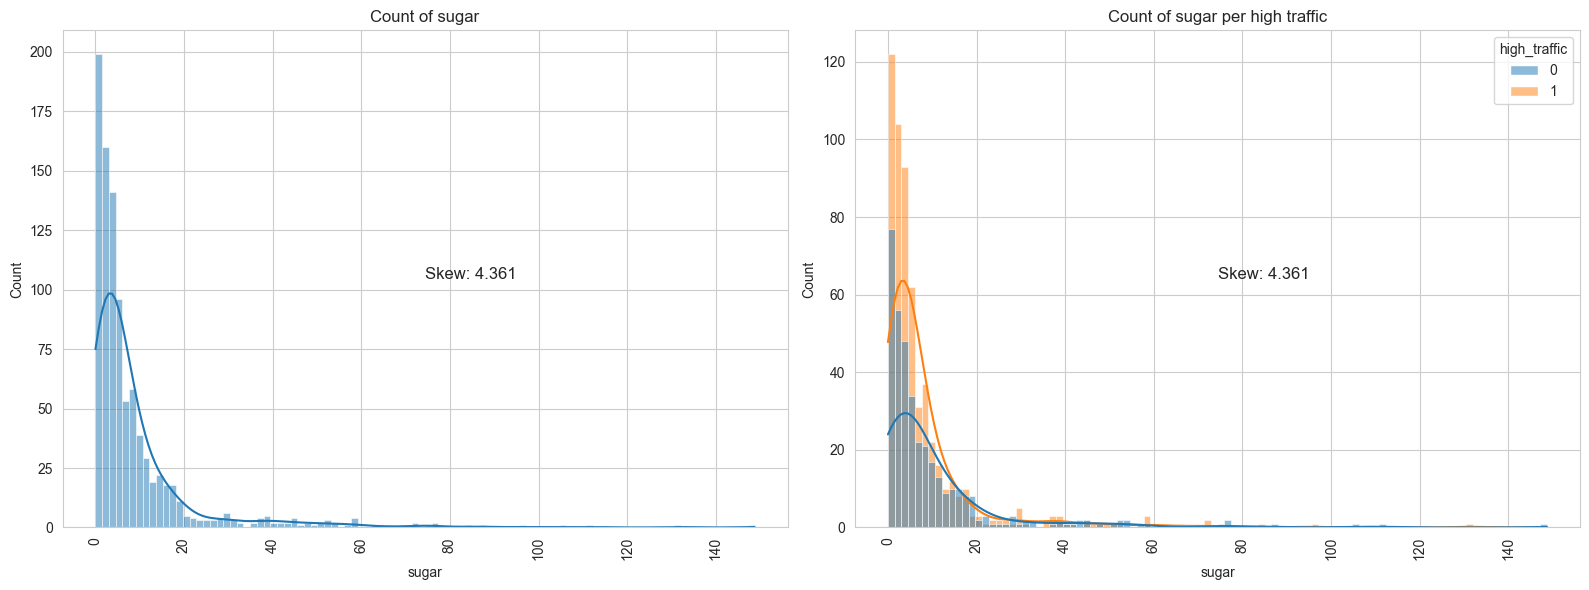

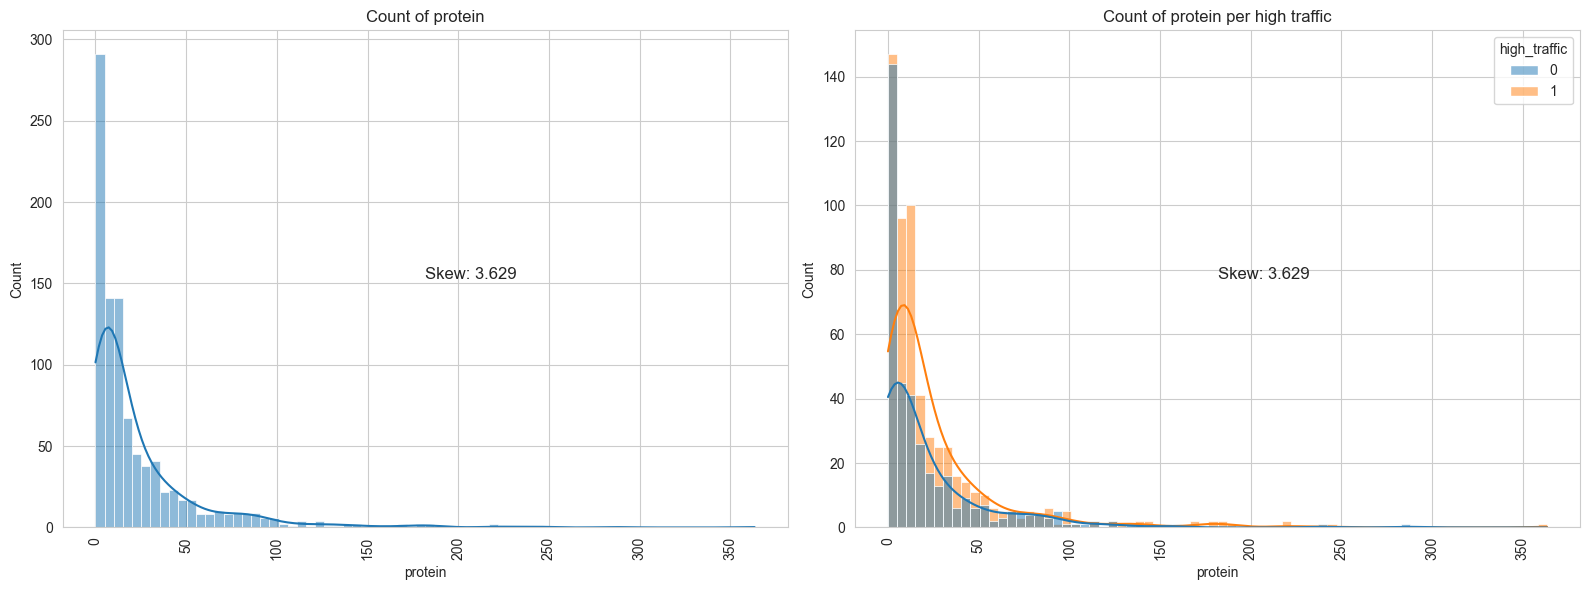

In [405]:
numerical_columns = df.select_dtypes(include=["float64"]).columns
print(numerical_columns)
numerical_columns_df = df.loc[:, numerical_columns]
numerical_columns_df.loc[:, "high_traffic"] = df.loc[:, "high_traffic"]

for column in numerical_columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(ax=axes[0], x=numerical_columns_df[column], kde=True)
    skew = numerical_columns_df[column].skew()
    axes[0].set_title(f"Count of {column}")
    axes[0].tick_params(axis="x", labelrotation=90)
    axes[0].text(
        0.5, 0.5, f"Skew: {skew:.3f}", transform=axes[0].transAxes, fontsize=12
    )
    sns.histplot(
        ax=axes[1],
        x=numerical_columns_df[column],
        hue=df["high_traffic"],
        kde=True,
    )

    axes[1].set_title(f"Count of {column} per high traffic")
    axes[1].tick_params(axis="x", labelrotation=90)
    axes[1].text(
        0.5, 0.5, f"Skew: {skew:.3f}", transform=axes[1].transAxes, fontsize=12
    )

    plt.tight_layout()
    plt.show()

# Encoding categorical columns

In [406]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for column in categorical_columns:
    df[f"{column}_encoded"] = label_encoder.fit_transform(df[column])

df = df.drop(columns=categorical_columns)

# Transforming numerical columns

Boxcox transformation not possible for protein


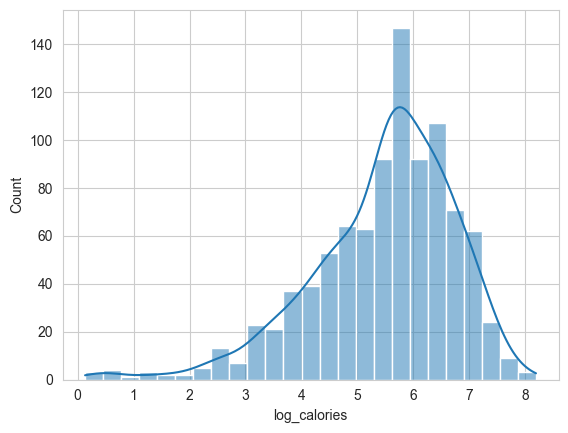

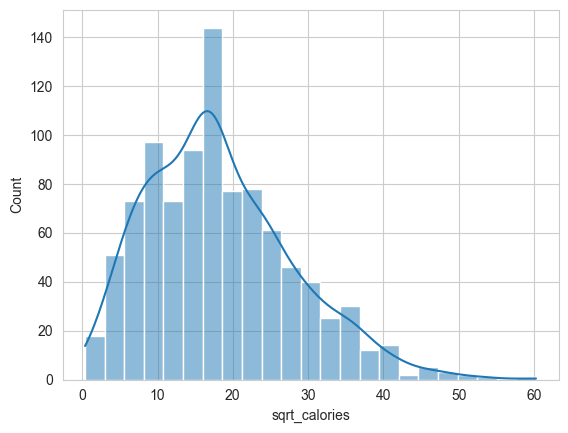

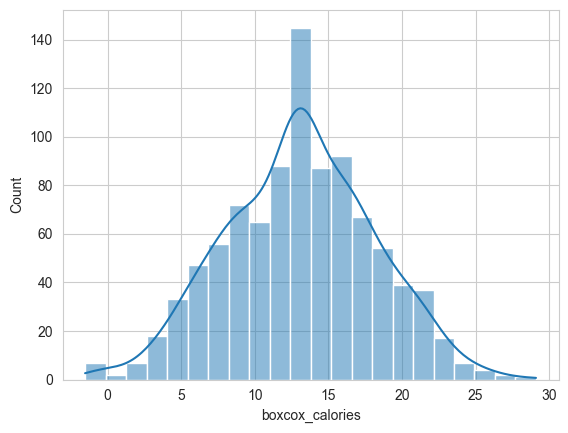

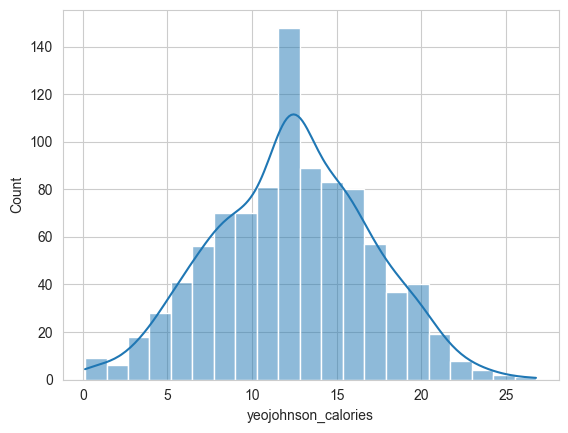

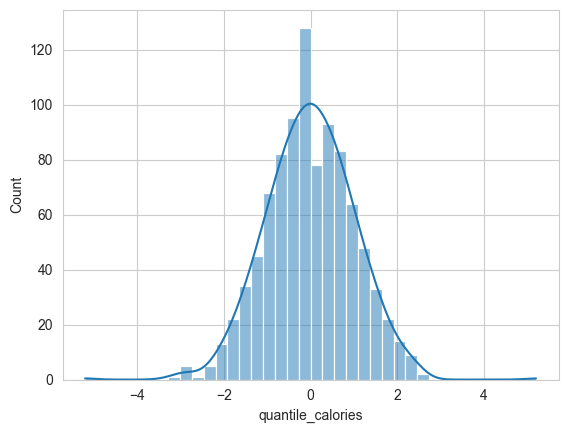

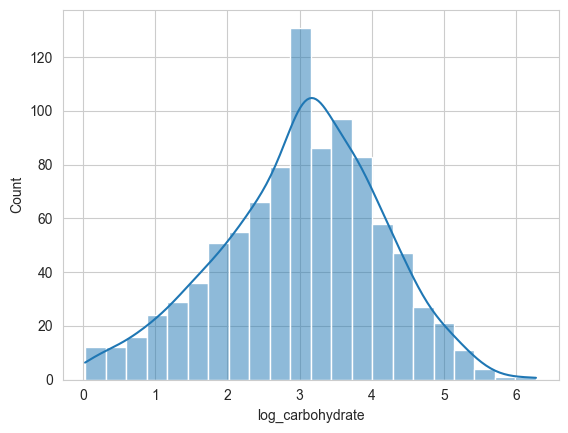

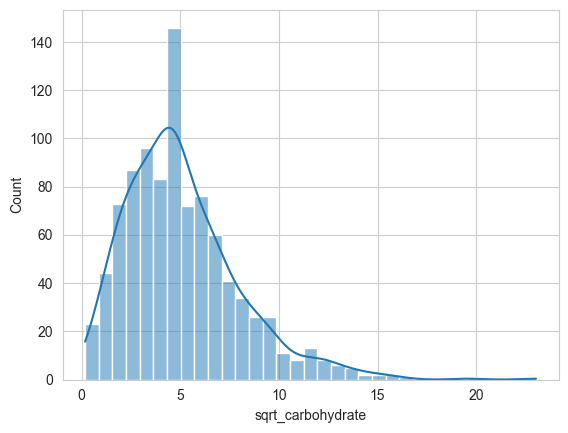

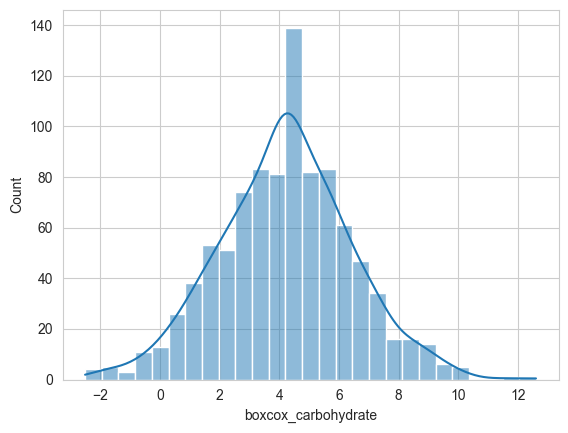

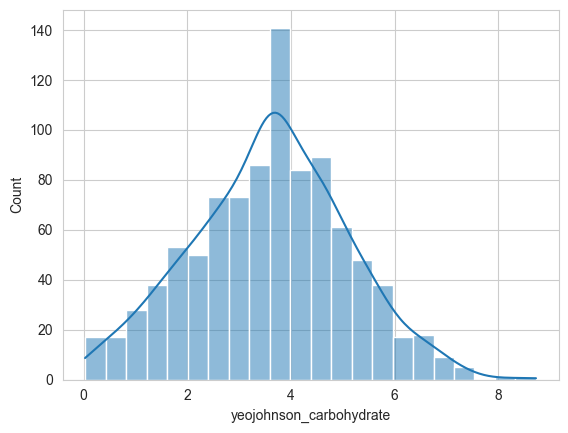

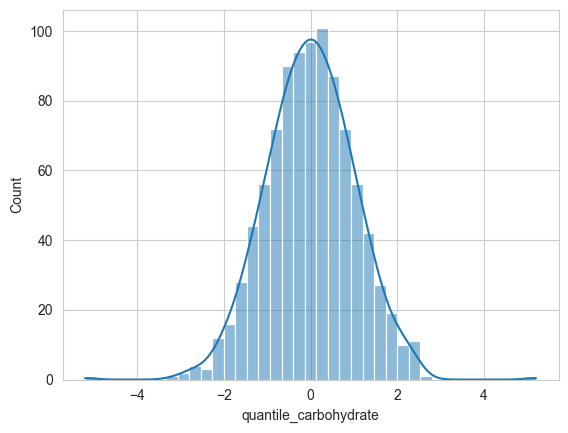

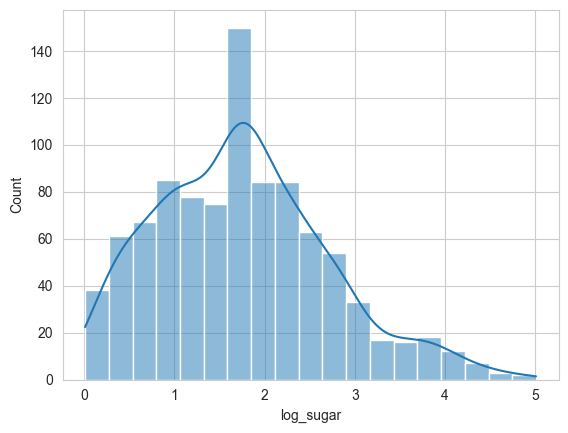

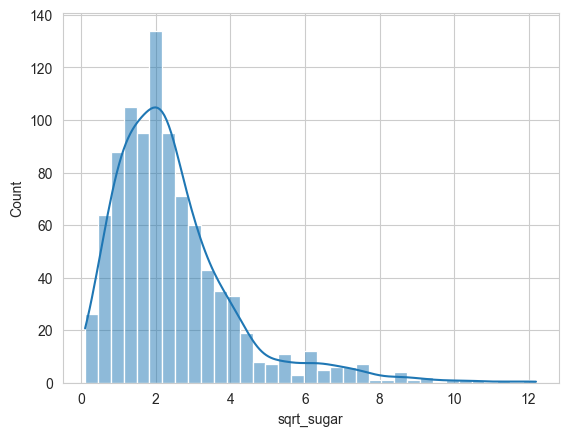

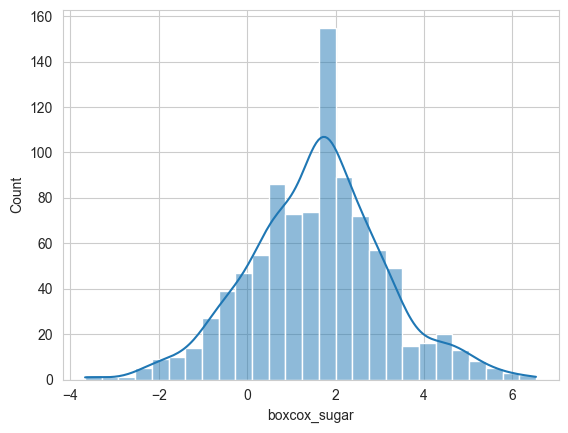

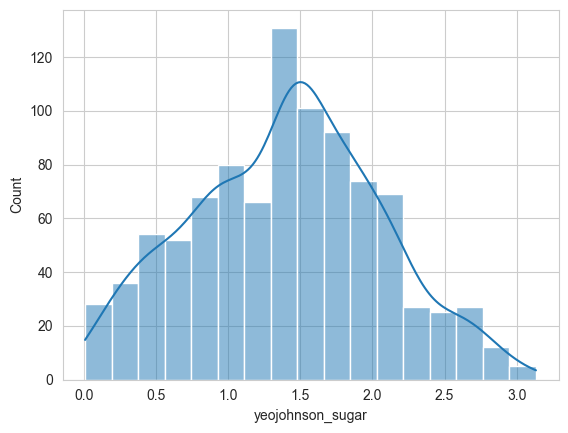

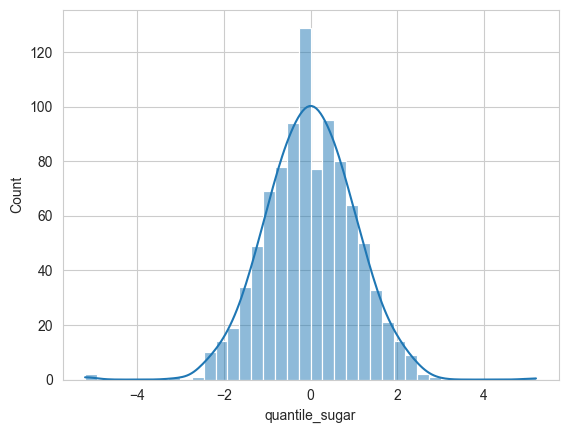

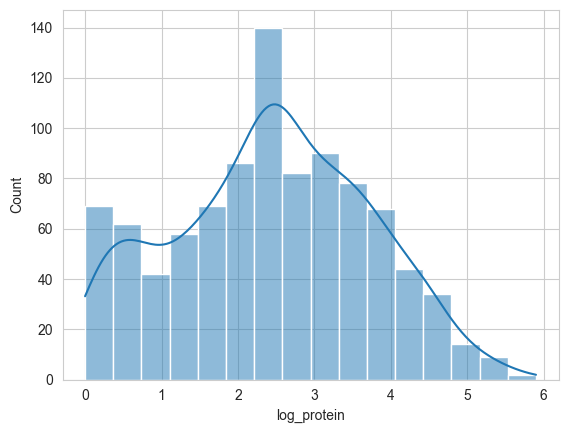

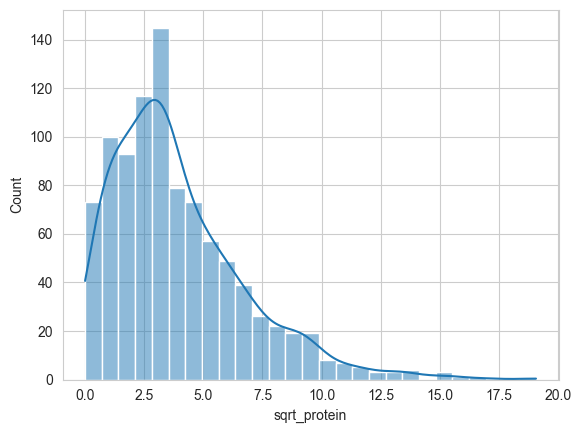

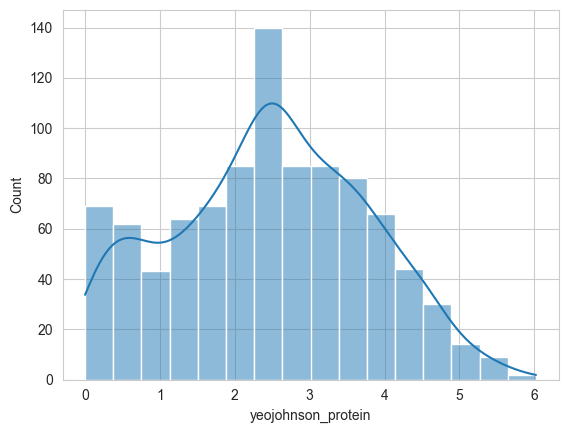

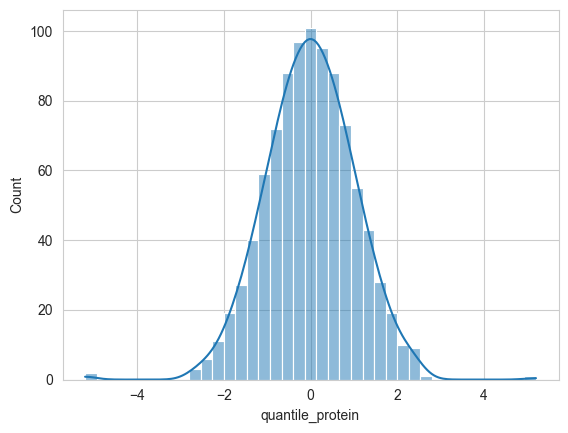

In [407]:
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import QuantileTransformer

numerical_transformation_df = pd.DataFrame()

for column in numerical_columns:
    numerical_transformation_df[f"log_{column}"] = np.log1p(df[column])
    numerical_transformation_df[f"sqrt_{column}"] = np.sqrt(df[column])
    if df[column].min() > 0:
        numerical_transformation_df[f"boxcox_{column}"], _ = boxcox(df[column])
    else:
        print(f"Boxcox transformation not possible for {column}")
    numerical_transformation_df[f"yeojohnson_{column}"], _ = yeojohnson(df[column])

    qt = QuantileTransformer(output_distribution="normal", random_state=42, n_quantiles=100)
    numerical_transformation_df[f"quantile_{column}"] = qt.fit_transform(
        df[column].values.reshape(-1, 1)
    )


for column in numerical_transformation_df.columns:
    sns.histplot(x=numerical_transformation_df[column], kde=True)
        
    plt.show()

In [408]:
from scipy.stats import kstest

ks_test_results = dict()
for transformation in numerical_transformation_df.columns:
    standardized_data = (numerical_transformation_df[transformation] - numerical_transformation_df[transformation].mean()) / numerical_transformation_df[transformation].std()
    ks_stat, ks_p_value = kstest(standardized_data, "norm")
    ks_test_results[transformation] = (ks_stat, ks_p_value)


ks_test_results_df = pd.DataFrame.from_dict(ks_test_results, orient="index", columns=["KS Statistic", "P-Value"])
print(ks_test_results_df.round(5))

                         KS Statistic  P-Value
log_calories                  0.09636  0.00000
sqrt_calories                 0.08231  0.00000
boxcox_calories               0.03382  0.22389
yeojohnson_calories           0.03554  0.17836
quantile_calories             0.02961  0.37041
log_carbohydrate              0.06502  0.00064
sqrt_carbohydrate             0.09433  0.00000
boxcox_carbohydrate           0.03586  0.17090
yeojohnson_carbohydrate       0.04335  0.05526
quantile_carbohydrate         0.03007  0.35180
log_sugar                     0.04667  0.03127
sqrt_sugar                    0.12858  0.00000
boxcox_sugar                  0.04537  0.03927
yeojohnson_sugar              0.05404  0.00763
quantile_sugar                0.03060  0.33130
log_protein                   0.04769  0.02606
sqrt_protein                  0.11778  0.00000
yeojohnson_protein            0.04727  0.02812
quantile_protein              0.03072  0.32668


In [409]:
yeojohnson_columns = numerical_transformation_df.filter(like="yeojohnson")

df = pd.concat([df, yeojohnson_columns], axis=1)
df = df.drop(columns=numerical_columns)
df

,high_traffic,category_encoded,servings_encoded,yeojohnson_calories,yeojohnson_carbohydrate,yeojohnson_sugar,yeojohnson_protein
0,1,8,4,12.416265,3.651219,1.445558,2.489758
1,1,9,2,5.807194,4.444895,0.481424,0.653832
2,0,1,0,17.850869,4.588695,1.223738,1.362354
3,1,0,2,8.541219,4.122245,2.585342,0.019804
4,0,0,2,5.186333,1.104103,0.553815,0.425908
...,...,...,...,...,...,...,...
942,0,5,1,19.185508,2.022643,2.323103,3.863357
943,1,9,1,12.416265,3.651219,1.445558,2.489758
944,1,8,1,18.069689,4.070391,1.305983,2.725267
945,1,9,4,12.097893,4.339650,0.633101,2.222248


# Model Training

In [410]:
df.head()

,high_traffic,category_encoded,servings_encoded,yeojohnson_calories,yeojohnson_carbohydrate,yeojohnson_sugar,yeojohnson_protein
0,1,8,4,12.416265,3.651219,1.445558,2.489758
1,1,9,2,5.807194,4.444895,0.481424,0.653832
2,0,1,0,17.850869,4.588695,1.223738,1.362354
3,1,0,2,8.541219,4.122245,2.585342,0.019804
4,0,0,2,5.186333,1.104103,0.553815,0.425908


In [411]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop(columns=["high_traffic"])
y = df["high_traffic"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

param_grid = {
    "n_estimators": [20, 50],  # Number of trees in the forest
    "max_depth": [None, 10, 20, 30],  # Maximum depth of the trees
    "min_samples_split": [
        10,
        15
    ],  # Minimum number of samples required to split an internal node
    "min_samples_leaf": [
        4,
        6
    ],  # Minimum number of samples required to be at a leaf node
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1
)

grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found:")
print(grid_search.best_params_)
print()

# Evaluate on test set with best estimator
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 50}

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.62      0.68        77
           1       0.77      0.85      0.81       113

    accuracy                           0.76       190
   macro avg       0.75      0.74      0.74       190
weighted avg       0.76      0.76      0.75       190

